# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import random
from collections import deque
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the Agent

In [5]:
def ddpg_train(agent):
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 2000
    best_score = -np.Inf

    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations
        agent.reset()                                                # reset the agent noise
        score = np.zeros(num_agents)
        
        while True:
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]                 # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished        

            agent.step(states[0], actions[0], rewards[0], next_states[0], dones[0], learn=True) # update the score
            agent.step(states[1], actions[1], rewards[1], next_states[1], dones[1], learn=False) # update the score

            score += rewards                                         
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any(dones):                                      # exit loop if episode finished        
                break                                        

        scores.append(np.max(score))
        scores_window.append(np.max(score))

        print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}'.format(episode, 
                                                                                  np.mean(scores_window), 
                                                                                  np.max(scores)), end="")
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(episode, 
                                                               np.mean(scores_window)))
        if np.mean(scores_window) > best_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            best_score = np.mean(scores_window)
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\t\tAverage Score: {:.3f}'.format(episode-100, np.mean(scores_window)))
            break

    plt.plot(np.arange(1, len(scores)+1), scores, label='score')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()    

Episode 0	Average Score: 0.100	Max Score: 0.100
Episode 100	Average Score: 0.000	Max Score: 0.100
Episode 200	Average Score: 0.059	Max Score: 0.500
Episode 300	Average Score: 0.167	Max Score: 0.800
Episode 400	Average Score: 0.273	Max Score: 2.100
Episode 500	Average Score: 0.354	Max Score: 2.100
Episode 598	Average Score: 0.510	Max Score: 2.600
Environment solved in 498 episodes!		Average Score: 0.510


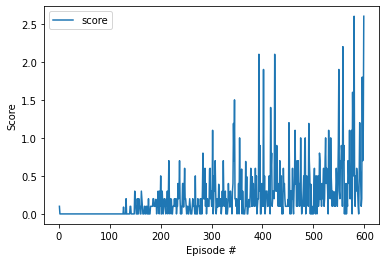

In [6]:
from ddpg_agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(device, 
              num_agents, 
              state_size, 
              action_size,
              random_seed=40,
              buffer_size=int(1e5), # replay buffer size
              batch_size=128,       # minibatch size
              gamma=0.99,           # discount factor
              tau=1e-2,             # for soft update of target parameters
              fc1_units_actor=256,  # output dim of first FC layer of actor
              fc2_units_actor=256,  # output dim of second FC layer of actor
              fcs1_units_critic=256,# output dim of first FC layer of critic
              fc2_units_critic=256, # output dim of second FC layer of critic
              lr_actor=1e-3,        # learning rate of the actor 
              lr_critic=1e-3,       # learning rate of the critic
              weight_decay=0,       # L2 weight decay
              update_local=1,
              n_updates=1)       


# train the agent
ddpg_train(agent)

When finished, you can close the environment.

### 4. Watch a Trained Agent

In [8]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
                  
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.600000038743019


In [9]:
env.close()